In [1]:
2+2

4

In [138]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn as sk
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import optuna
import xgboost as xgb


In [3]:
ml_data = pd.read_csv("../data/ml_data.csv")

In [394]:
ml_data[targets].replace(0.0, -999)

,high,low,medium
0,-999.0,-999.0,4042.0
1,-999.0,4043.0,-999.0
2,5052.5,4041.0,2022.0
3,-999.0,4043.0,2020.0
4,-999.0,2020.0,2021.0
...,...,...,...
148462,-999.0,-999.0,2021.0
148463,-999.0,-999.0,4043.0
148464,-999.0,2021.0,-999.0
148465,-999.0,2020.0,-999.0


In [395]:
targets = ['high','low','medium']
# targets='high'

predictors = ['District', 'Sector', 
              'month_num', 'day', 
              'call_hour', 'season']

ml_data = replace_outliers(ml_data,['high','medium','low'])

cat_preds = ml_data[['District','Sector','season']]
num_preds = ml_data[['month_num', 'day','call_hour']]

enc = OneHotEncoder(handle_unknown='ignore')
cat_preds = enc.fit_transform(cat_preds)
cat_preds = cat_preds.toarray()
cat_preds = pd.DataFrame(cat_preds)

X = pd.concat([num_preds,cat_preds],axis=1)





# process Y variable
Y = ml_data[targets]

y_std = ml_data[targets].std()
y_mean = ml_data[targets].mean()

print(y_std)
print()
print(y_mean)
print()

# standardize µ=0, ∑=1
# X = ( X - X.mean() ) / X.std()
Y = ( Y - y_mean) / y_std

print(Y.shape)
print(Y.head())
print()

print(X.head())
print(X.shape)


# split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=888, test_size=.20)


high      1384.878192
low       1546.117004
medium    2233.858427
dtype: float64

high       862.534849
low       1276.541191
medium    2992.303640
dtype: float64

(148467, 3)
       high       low    medium
0 -0.622824 -0.825643  0.469903
1 -0.622824  1.789295 -1.339523
2  3.025512  1.788001 -0.434362
3 -0.622824  1.789295 -0.435258
4 -0.622824  0.480855 -0.434810

   month_num  day  call_hour    0    1    2    3    4    5    6  ...   22  \
0          4    4          8  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
1          4   14         19  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   
2          5   17         16  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
3          3   13          7  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
4          5   14          6  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  1.0   

    23   24   25   26   27   28   29   30   31  
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
1  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  
2  0.0  0.0  0.0  0.0

In [396]:
y_test

,high,low,medium
53868,0.837233,-0.825643,-1.339523
124843,-0.622824,0.481502,-1.339523
46318,-0.622824,-0.825643,-0.434362
52820,-0.622824,0.480855,-0.434362
112722,0.836511,-0.825643,-0.434362
...,...,...,...
12317,-0.622824,-0.825643,0.469903
57158,0.837233,0.480855,-0.435258
19696,-0.622824,0.480855,0.469455
101408,0.837233,0.482149,0.469455


In [397]:
def replace_outliers(df, columns):
    
    for col in columns:

        # Calculate Q1 and Q3
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)

        # Calculate IQR
        IQR = Q3 - Q1

        # Define Outlier Thresholds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifying outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

    return df

In [398]:
def objective(trial, X_data = X, Y_data = Y):
    print(1)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        X_data, Y_data, random_state= 888, test_size = 0.20)
    
    # params copied from notebook
    param = {
        'tree_method':'hist',  # this parameter means using the GPU when training our model to speedup the training process
        'device' : "cuda",
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, 500),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        
    }
    
    model = xgb.XGBRegressor(**param)  
    
    model.fit(x_train,y_train,eval_set=[(x_train,y_train)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(x_test)
    
    rmse = mean_squared_error(y_test, preds,squared=True)
    
    return rmse

In [24]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)


  0%|          | 0/50 [00:00<?, ?it/s]

1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


[0]	validation_0-rmse:0.99900


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.91840
[1000]	validation_0-rmse:0.89708
[1500]	validation_0-rmse:0.88121
[2000]	validation_0-rmse:0.86799
[2500]	validation_0-rmse:0.85682
[3000]	validation_0-rmse:0.84670
[3499]	validation_0-rmse:0.83776


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


[0]	validation_0-rmse:0.99902


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93995
[999]	validation_0-rmse:0.93514


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99917


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93845
[1000]	validation_0-rmse:0.93267
[1499]	validation_0-rmse:0.92910


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99909


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93631
[1000]	validation_0-rmse:0.92937
[1500]	validation_0-rmse:0.92501
[1908]	validation_0-rmse:0.92405


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99903


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93441
[999]	validation_0-rmse:0.92761


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99834


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.92559
[1000]	validation_0-rmse:0.91219
[1500]	validation_0-rmse:0.90256
[2000]	validation_0-rmse:0.89477
[2500]	validation_0-rmse:0.88815
[3000]	validation_0-rmse:0.88239
[3500]	validation_0-rmse:0.87720
[4000]	validation_0-rmse:0.87246
[4500]	validation_0-rmse:0.86812
[4999]	validation_0-rmse:0.86407


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


[0]	validation_0-rmse:0.99817


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93788
[1000]	validation_0-rmse:0.93246
[1500]	validation_0-rmse:0.92867
[2000]	validation_0-rmse:0.92567
[2500]	validation_0-rmse:0.92308
[3000]	validation_0-rmse:0.92081
[3500]	validation_0-rmse:0.91874
[4000]	validation_0-rmse:0.91687
[4499]	validation_0-rmse:0.91515


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99929


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94184
[1000]	validation_0-rmse:0.93665
[1500]	validation_0-rmse:0.93320
[1999]	validation_0-rmse:0.93064


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99729


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[499]	validation_0-rmse:0.83513


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99860


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.89664
[1000]	validation_0-rmse:0.86381
[1500]	validation_0-rmse:0.83992
[2000]	validation_0-rmse:0.82182
[2500]	validation_0-rmse:0.80659
[2999]	validation_0-rmse:0.79403


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


[0]	validation_0-rmse:0.99915


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94405
[1000]	validation_0-rmse:0.94031
[1500]	validation_0-rmse:0.93801
[1999]	validation_0-rmse:0.93639


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99915


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94404
[1000]	validation_0-rmse:0.94030
[1500]	validation_0-rmse:0.93801
[1999]	validation_0-rmse:0.93637


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99915


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94396
[1000]	validation_0-rmse:0.94015
[1500]	validation_0-rmse:0.93779
[1999]	validation_0-rmse:0.93611


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99915


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94394
[1000]	validation_0-rmse:0.94009
[1500]	validation_0-rmse:0.93769
[2000]	validation_0-rmse:0.93598
[2499]	validation_0-rmse:0.93456


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99934


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94695
[1000]	validation_0-rmse:0.94271
[1500]	validation_0-rmse:0.94057
[2000]	validation_0-rmse:0.93916
[2499]	validation_0-rmse:0.93794


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99922


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93025
[1000]	validation_0-rmse:0.91872
[1500]	validation_0-rmse:0.91085
[2000]	validation_0-rmse:0.90495
[2500]	validation_0-rmse:0.90001
[2999]	validation_0-rmse:0.89538


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


[0]	validation_0-rmse:0.99915


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94483
[1000]	validation_0-rmse:0.94156
[1500]	validation_0-rmse:0.93964
[2000]	validation_0-rmse:0.93828
[2500]	validation_0-rmse:0.93712
[3000]	validation_0-rmse:0.93611
[3500]	validation_0-rmse:0.93524
[3999]	validation_0-rmse:0.93446


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94226
[1000]	validation_0-rmse:0.93748
[1500]	validation_0-rmse:0.93429
[2000]	validation_0-rmse:0.93184
[2499]	validation_0-rmse:0.92975


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99918


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93060
[1000]	validation_0-rmse:0.92052
[1499]	validation_0-rmse:0.91343


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99896


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.90090
[1000]	validation_0-rmse:0.87335
[1500]	validation_0-rmse:0.85356
[2000]	validation_0-rmse:0.83814
[2500]	validation_0-rmse:0.82508
[3000]	validation_0-rmse:0.81349
[3499]	validation_0-rmse:0.80341


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


[0]	validation_0-rmse:0.99928


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93981
[1000]	validation_0-rmse:0.93045
[1499]	validation_0-rmse:0.92507


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94234
[1000]	validation_0-rmse:0.93761
[1500]	validation_0-rmse:0.93448
[2000]	validation_0-rmse:0.93205
[2499]	validation_0-rmse:0.93001


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94268
[1000]	validation_0-rmse:0.93821
[1500]	validation_0-rmse:0.93529
[2000]	validation_0-rmse:0.93307
[2499]	validation_0-rmse:0.93121


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94275
[1000]	validation_0-rmse:0.93841
[1500]	validation_0-rmse:0.93557
[2000]	validation_0-rmse:0.93343
[2500]	validation_0-rmse:0.93163
[2999]	validation_0-rmse:0.93002


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94258
[1000]	validation_0-rmse:0.93810
[1500]	validation_0-rmse:0.93518
[1999]	validation_0-rmse:0.93295


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94295
[1000]	validation_0-rmse:0.93870
[1500]	validation_0-rmse:0.93595
[2000]	validation_0-rmse:0.93386
[2499]	validation_0-rmse:0.93211


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94301
[999]	validation_0-rmse:0.93889


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94232
[1000]	validation_0-rmse:0.93751
[1500]	validation_0-rmse:0.93430
[2000]	validation_0-rmse:0.93181
[2500]	validation_0-rmse:0.92970
[3000]	validation_0-rmse:0.92785
[3500]	validation_0-rmse:0.92616
[3999]	validation_0-rmse:0.92465


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99878


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.92483
[1000]	validation_0-rmse:0.91001
[1500]	validation_0-rmse:0.89942
[2000]	validation_0-rmse:0.89089
[2500]	validation_0-rmse:0.88373
[2999]	validation_0-rmse:0.87742


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),


[0]	validation_0-rmse:0.99924


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.92717
[1000]	validation_0-rmse:0.91309
[1500]	validation_0-rmse:0.90244
[1999]	validation_0-rmse:0.89461


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99810


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.92293
[1000]	validation_0-rmse:0.90971
[1499]	validation_0-rmse:0.90029


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94239
[1000]	validation_0-rmse:0.93775
[1500]	validation_0-rmse:0.93469
[1999]	validation_0-rmse:0.93236


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99851


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93943
[1000]	validation_0-rmse:0.93446
[1500]	validation_0-rmse:0.93109
[2000]	validation_0-rmse:0.92836
[2499]	validation_0-rmse:0.92609


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99913


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94699
[1000]	validation_0-rmse:0.94234
[1500]	validation_0-rmse:0.93968
[1999]	validation_0-rmse:0.93760


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99913


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[499]	validation_0-rmse:0.94712


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99893


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93303
[1000]	validation_0-rmse:0.92300
[1499]	validation_0-rmse:0.91586


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99929


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93240
[999]	validation_0-rmse:0.92107


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99802


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.91889
[1000]	validation_0-rmse:0.90310
[1500]	validation_0-rmse:0.89175
[1999]	validation_0-rmse:0.88250


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99923


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94160
[1000]	validation_0-rmse:0.93636
[1500]	validation_0-rmse:0.93281
[2000]	validation_0-rmse:0.93015
[2500]	validation_0-rmse:0.92789
[3000]	validation_0-rmse:0.92597
[3499]	validation_0-rmse:0.92409


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99880


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.92819
[1000]	validation_0-rmse:0.91535
[1499]	validation_0-rmse:0.90644


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99830


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93061
[1000]	validation_0-rmse:0.92256
[1500]	validation_0-rmse:0.91669
[1999]	validation_0-rmse:0.91192


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99864


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94269
[1000]	validation_0-rmse:0.93832
[1500]	validation_0-rmse:0.93544
[2000]	validation_0-rmse:0.93326
[2499]	validation_0-rmse:0.93142


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99876


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94341
[1000]	validation_0-rmse:0.93900
[1500]	validation_0-rmse:0.93608
[2000]	validation_0-rmse:0.93387
[2500]	validation_0-rmse:0.93203
[2999]	validation_0-rmse:0.93041


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99900


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94532
[1000]	validation_0-rmse:0.94088
[1500]	validation_0-rmse:0.93801
[1999]	validation_0-rmse:0.93582


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99900


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94534
[999]	validation_0-rmse:0.94088


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99871


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.93459
[1000]	validation_0-rmse:0.92591
[1500]	validation_0-rmse:0.91973
[1999]	validation_0-rmse:0.91484


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99900


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94500
[1000]	validation_0-rmse:0.94030
[1499]	validation_0-rmse:0.93718


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99938


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.95110
[1000]	validation_0-rmse:0.94485
[1499]	validation_0-rmse:0.94263


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99856


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[499]	validation_0-rmse:0.91618


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_815/1534663695.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fe

1
[0]	validation_0-rmse:0.99904


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:0.94496
[999]	validation_0-rmse:0.94010


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [399]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best objective value:', study.best_value)

Number of finished trials: 50
Best trial: {'lambda': 2.758935525314534, 'alpha': 0.3996817382336355, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.01, 'n_estimators': 2000, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 88}
Best objective value: 0.8965955260667688


In [400]:
best_params = {'lambda': 2.758935525314534,
               'alpha': 0.3996817382336355, 
               'colsample_bytree': 0.9, 
               'subsample': 0.8, 
               'learning_rate': 0.01, 
               'n_estimators': 2000, 
               'max_depth': 5,
               'random_state': 24, 
               'min_child_weight': 88}

In [401]:
opt_model = xgb.XGBRegressor(**best_params)

opt_model.fit(x_train,y_train)


XGBRegressor(alpha=0.3996817382336355, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=2.758935525314534,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=88, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, ...)

In [402]:
preds = opt_model.predict(x_test)
mse = mean_squared_error(y_test, preds,squared=False)
mse

/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.9463929135176717

In [403]:
preds

array([[-0.10924865,  0.05112735,  0.10970945],
       [-0.31231308, -0.17622606, -0.57154316],
       [-0.1363577 , -0.25043464, -0.15964276],
       ...,
       [ 0.3021018 , -0.08159421,  0.2265624 ],
       [ 0.3878931 ,  0.6672816 ,  1.027588  ],
       [-0.25786388,  0.09099835, -0.5614776 ]], dtype=float32)

In [404]:
preds = preds 
preds

array([[-0.10924865,  0.05112735,  0.10970945],
       [-0.31231308, -0.17622606, -0.57154316],
       [-0.1363577 , -0.25043464, -0.15964276],
       ...,
       [ 0.3021018 , -0.08159421,  0.2265624 ],
       [ 0.3878931 ,  0.6672816 ,  1.027588  ],
       [-0.25786388,  0.09099835, -0.5614776 ]], dtype=float32)

In [405]:
pred_val = pd.DataFrame(preds, columns =['pred_high', 'pred_low', 'pred_medium'])
pred_true = pd.concat([pred_val, y_test.reset_index(drop=True)],axis=1)
pred_true

for col in pred_true.columns:
    if 'high' in col:
        
        pred_true[col]=pred_true[col].apply(lambda x: x*1384.878192 + 862)
        pred_true[col]=pred_true[col].apply(lambda x: 0 if x < 1 else round(x))
        
    elif 'low' in col:
        pred_true[col]=pred_true[col].apply(lambda x: x*2739 +1276)
        pred_true[col]=pred_true[col].apply(lambda x: 0 if x < 1 else round(x))
        
    elif 'med' in col:
        pred_true[col]=pred_true[col].apply(lambda x: x*2233 +2992)
        pred_true[col]=pred_true[col].apply(lambda x: 0 if x < 1 else round(x))
        
    if 'pred' in col:
        pred_true[col]=pred_true[col].apply(lambda x: round(x))
pred_true

,pred_high,pred_low,pred_medium,high,low,medium
0,711,1416,3237,2021,0,0
1,429,793,1716,0,2595,0
2,673,590,2636,0,0,2022
3,453,235,2685,0,2593,2022
4,568,1075,3282,2020,0,2022
...,...,...,...,...,...,...
29689,1343,1379,4044,0,0,4041
29690,791,1170,3834,2021,2593,2020
29691,1280,1053,3498,0,2593,4040
29692,1399,3104,5287,2021,2597,4040


# predict call type

In [327]:
# seasonality
def seasonality(date):
    """
    Return the season given the date.

    date: Exception date 
    
    date thresholds are referenced from
    https://www.timeanddate.com/calendar/seasons.html
    """
    date = str(date)
    if date < "2020-03-19":
        return "winter"
    
    elif date < "2020-06-20":
        return "spring"
    
    elif date < "2020-09-22":
        return "summer"
    
    elif date < "2020-12-21":
        return "fall"
    
    elif date < "2021-03-20":
        return "winter"
    
    elif date < "2021-06-20":
        return "spring"
    
    elif date < "2021-09-22":
        return "summer"
    
    elif date < "2021-12-21":
        return "fall"
    
    elif date < "2022-03-20":
        return "winter"
    
    elif date < "2022-06-21":
        return "spring"
    
    elif date < "2022-09-22":
        return "summer"
    
    elif date < "2022-12-21":
        return "fall"
    
    else:
        return "winter"
    
    
def shifts(x):
    
    if x < 7:
        return 'night'
    elif x <  15:
        return 'day'
    elif x < 23 :
        return 'evening'
    else:
        return 'night'
    

In [334]:
crime_df= pd.read_csv("../data/clean_crime_df.csv")
crime_df['season'] = crime_df['Call Date'].apply(seasonality)
crime_df['shift'] = crime_df['call_hour'].apply(shifts)
crime_df['District'] = crime_df['District'].apply(str)
crime_df['Sector'] = crime_df['Sector'].apply(str)
crime_df.head()

,Call Date,call_time,District,Sector,Call Type,year,month,day,call_hour,month_day,priority,month_num,season,shift
0,2020-01-01,00:05:46,2,21,UNKNOWN TROUBLE,2020,Jan,1,0,Jan-01,high,1,winter,night
1,2020-01-01,02:06:01,4,44,ASSAULT IN PROGRESS,2020,Jan,1,2,Jan-01,high,1,winter,night
2,2020-01-01,00:37:32,5,55,FIRE,2020,Jan,1,0,Jan-01,high,1,winter,night
3,2020-01-01,01:41:30,5,55,CHECK WELFARE,2020,Jan,1,1,Jan-01,medium,1,winter,night
4,2020-01-01,00:46:26,1,13,DOMESTIC VIOLENCE,2020,Jan,1,0,Jan-01,high,1,winter,night


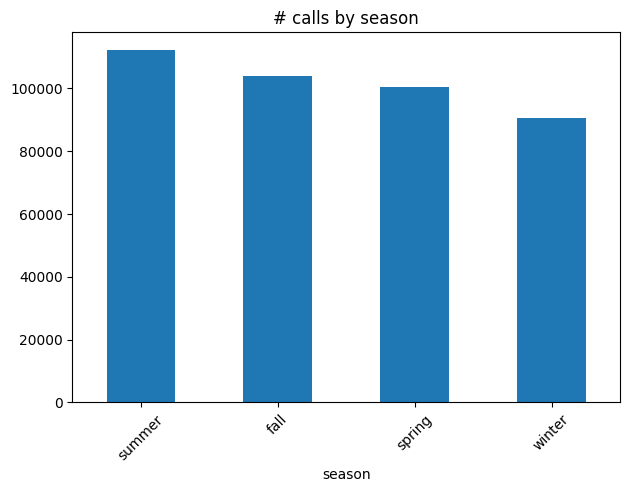

In [335]:
import matplotlib.pyplot as plt
crime_df['season'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('# calls by season')
plt.show()

In [363]:
def categorize_crime(crime):
    if crime in ['ABANDONED VEHICLE', 'ACCIDENT FARM', 'ACCIDENT INDUSTRIAL', 'AIRCRAFT']:
        return 'Accidents'
    elif crime in ['ABDUCTION', 'ABUSE CHILD', 'ABUSE ELDER']:
        return 'Abuse'
    elif crime.startswith('ALARM'):
        return 'Alarm'
    elif crime in ['ANIMAL COMPLAINT', 'ANIMAL COMPLAINT - DOMESTIC ANIMAL', 'ANIMAL COMPLAINT - LIVESTOCK ANIMAL', 'ANIMAL COMPLAINT - WILD ANIMAL']:
        return 'Animal Related'
    elif 'ASSAULT' in crime:
        return 'Assault'
    elif 'BREAK' in crime:
        return 'Break-in'
    elif 'DOMESTIC' in crime:
        return 'Domestic'
    elif 'DRUGS' in crime:
        return 'Drugs'
    elif 'FRAUD' in crime:
        return 'Fraud'
    elif 'HARASSMENT' in crime:
        return 'Harassment'
    elif 'MISSING' in crime:
        return 'Missing Person'
    elif 'MVC' in crime:
        return 'Motor Vehicle Collision'
    elif 'NOISE COMPLAINT' in crime or 'PARKING COMPLAINT' in crime:
        return 'Complaint'
    elif 'ROBBERY' in crime:
        return 'Robbery'
    elif 'SEX' in crime:
        return 'Sexual Offence'
    elif 'THEFT' in crime or 'SHOPLIFTING' in crime:
        return 'Theft'
    elif 'WEAPONS CALL' in crime:
        return 'Weapons'
    elif 'ARU' in crime:
        return 'ARU - Related'
    elif 'IMPAIRED' in crime or 'DRIVING HAZARD' in crime or 'SOBRIETY' in crime :
        return 'IMPAIRED (DRIVING)'
    elif 'WELFARE' in crime or 'ALL OK' in crime or 'PEACE' in crime or 'ACCIDENT CALL' in crime or 'SECURITY TO CHECK' in crime:
        return 'WELFARE'
    else:
        return 'Other'
    


In [364]:
crime_df['cat_crime'] = crime_df['Call Type'].apply(categorize_crime)


crime_df[
    crime_df['cat_crime']=='Other'
][['cat_crime','Call Type']]['Call Type'].nunique()

63

In [365]:
X = crime_df[['shift','season', 'District','Sector','month_num','day','call_hour']]

target = 'cat_crime'
Y_unlabeled= crime_df[target]

cat_preds = X[['shift','season', 'District','Sector']]
num_preds = X[['month_num','day','call_hour']]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cat_preds)



cat_preds = enc.transform(cat_preds).toarray()
cat_preds = pd.DataFrame(cat_preds, index = num_preds.index)


X = pd.concat([num_preds,cat_preds],axis=1)



# get label y values
label_encoder = LabelEncoder()
Y = pd.DataFrame(label_encoder.fit_transform(crime_df[target]))



x_train, x_test, y_train, y_test = model_selection.train_test_split(
    X, Y, 
    random_state=888, 
    test_size=0.20)



In [366]:
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_to_class = {y: x for x, y in le_name_mapping.items()}
label_list = list(label_to_class.values())
label_list

['ARU - Related',
 'Abuse',
 'Accidents',
 'Alarm',
 'Animal Related',
 'Assault',
 'Break-in',
 'Complaint',
 'Domestic',
 'Drugs',
 'Fraud',
 'Harassment',
 'IMPAIRED (DRIVING)',
 'Missing Person',
 'Motor Vehicle Collision',
 'Other',
 'Robbery',
 'Sexual Offence',
 'Theft',
 'WELFARE',
 'Weapons']

In [367]:
label_to_class.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [368]:
def find_max_and_assign(row):
    # Extract the values for 'Sick', 'Training', and 'Vacation'
    values = row[label_list]
    
    # Find the column with the maximum value and return it
    return values.idxmax()

In [369]:
y_train

,0
220637,18
156044,19
282652,15
224794,20
334583,20
...,...
332950,14
58607,15
80365,4
100250,11


In [370]:
xgb_model = xgb.XGBClassifier(n_estimators=1000) # initialize tree

xgb_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb, columns = label_list)

prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],
                       axis=1)

prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)

print(classification_report(prob_preds[0], label_encoder.transform(prob_preds['y_pred'])))

KeyboardInterrupt: 

In [ ]:
predict_xgb_prob

In [346]:
label_encoder.transform(prob_preds['y_pred'])

array([15, 15, 15, ..., 15, 15, 15])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       128
           1       0.00      0.00      0.00       133
           2       0.00      0.00      0.00       202
           3       0.00      0.00      0.00      1829
           4       0.00      0.00      0.00       388
           5       0.00      0.00      0.00      1690
           6       0.00      0.00      0.00      1152
           7       0.41      0.12      0.18      1950
           8       0.00      0.00      0.00      6096
           9       0.00      0.00      0.00       268
          10       0.00      0.00      0.00      2005
          11       0.00      0.00      0.00       839
          12       0.00      0.00      0.00      3942
          13       0.00      0.00      0.00       712
          14       0.67      0.00      0.00      6221
          15       0.46      1.00      0.63     37381
          16       0.00      0.00      0.00       184
          17       0.00    

/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [348]:
crime_df['cat_crime'].nunique()

21

In [ ]:
def objective(trial, X_data = X, Y_data = Y):
    print(1)
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        X_data, Y_data, random_state= 888, test_size = 0.20)
    
    # params copied from notebook
    param = {
        'tree_method':'hist',  # this parameter means using the GPU when training our model to speedup the training process
        'device' : "cuda",
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, 500),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        
    }

    
    
    model = xgb.XGBClassifier(**param)  
    
    model.fit(x_train,y_train,eval_set=[(x_train,np.ravel(y_train))],early_stopping_rounds=100,verbose=500)
    
    predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

    predict_xgb_prob = pd.DataFrame(predict_xgb,columns = ['Sick','Training', 'Vacation'])

    prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)
    
    prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)

    
    report = classification_report(prob_preds[0], prob_preds['y_pred'], output_dict=True)

    
    metric = report['weighted avg']['recall'] 
    
    return metric

In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best objective value:', study.best_value)

In [55]:
cat_preds

,shift,season,District,Sector,month_num,day,call_hour
0,evening,winter,2,21,1,1,0
1,evening,winter,4,44,1,1,2
2,evening,winter,5,55,1,1,0
3,evening,winter,5,55,1,1,1
4,evening,winter,1,13,1,1,0
...,...,...,...,...,...,...,...
406783,evening,winter,5,55,12,31,23
406784,evening,winter,2,22,12,31,22
406785,evening,winter,2,22,12,31,21
406786,evening,winter,2,23,12,31,23


In [354]:
crime_df.dtypes

Call Date    object
call_time    object
District     object
Sector       object
Call Type    object
year          int64
month        object
day           int64
call_hour     int64
month_day    object
priority     object
month_num     int64
season       object
shift        object
cat_crime    object
dtype: object

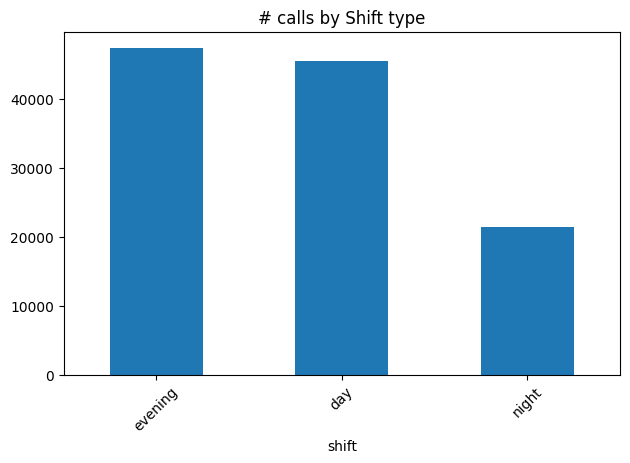

In [362]:
district_4 = crime_df[
    crime_df['District']=='4'
]


district_4[ 'shift'].value_counts().plot(kind='bar')
plt.title('# calls by Shift type')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()